In [1]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [2]:
#데이터 셋 가져오기
def get_mask_data():

    x_train_path = "dataset/Image_Segmentation/x_train2.npy"
    x_val_path = "dataset/Image_Segmentation/x_val2.npy" 
    y_train_path = "dataset/Image_Segmentation/y_train2.npy"
    y_val_path = "dataset/Image_Segmentation/y_val2.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    
        
    return x_train, y_train, x_val, y_val


In [3]:
# CNN 인 VGG16 U-net
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(2, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=['acc',tf.keras.metrics.MeanIoU(num_classes=2)])

    model.summary()
    
    
    

    return model

In [4]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    
    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')
    

#     preds = model.predict(x_val)
#     fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
#     temp = np.empty((256, 256, 1), dtype=np.float32)

#     for i in range(40):
#         ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
#         ax[i, 0].title.set_text(str(i))
    
#         y_val_0 = y_val[...,0]
#         ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
#         predict_0 = preds[...,0]
#         ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
#         temp = x_val[i]
#         pred_sum = predict_0[i][predict_0[i] > 0]
#         pred_mean = np.mean(predict_0)
#         if(np.min(temp) >= 0) :
#             temp[predict_0[i] < 0.5] = 0
#         else :
#             temp[predict_0[i] < 0.5] = -2048
#         ax[i, 3].imshow(temp.squeeze(), cmap='gray')


In [5]:
x_train, y_train, x_val, y_val = get_mask_data()
print(y_train.max(), y_train.min())
print(x_train.max(), x_train.min())
print(x_val.max(), x_val.min())
# model = VGG16_Unet(x_train, y_train2, x_val, y_val2)
# history = training(model,x_train, y_train2, x_val, y_val2)

(2675, 256, 256, 1) (2675, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)
1 0
1.0 0.0
1.0 0.0


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d_1[0][0]                   
______________________________________________________________________________________________

Epoch 1/30
168/168 [==============================] - 91s 468ms/step - loss: 0.2322 - acc: 0.9746 - mean_io_u: 0.2500 - val_loss: 0.3477 - val_acc: 0.8953 - val_mean_io_u: 0.2500
Epoch 2/30
168/168 [==============================] - 73s 436ms/step - loss: 0.0604 - acc: 0.9935 - mean_io_u: 0.2500 - val_loss: 0.0704 - val_acc: 0.9817 - val_mean_io_u: 0.2500
Epoch 3/30
168/168 [==============================] - 73s 436ms/step - loss: 0.0274 - acc: 0.9953 - mean_io_u: 0.2502 - val_loss: 0.0410 - val_acc: 0.9889 - val_mean_io_u: 0.2502
Epoch 4/30
168/168 [==============================] - 73s 436ms/step - loss: 0.0227 - acc: 0.9945 - mean_io_u: 0.2540 - val_loss: 0.0156 - val_acc: 0.9954 - val_mean_io_u: 0.2500
Epoch 5/30
168/168 [==============================] - 73s 436ms/step - loss: 0.0147 - acc: 0.9960 - mean_io_u: 0.2549 - val_loss: 0.0128 - val_acc: 0.9960 - val_mean_io_u: 0.2500
Epoch 6/30
168/168 [==============================] - 73s 436ms/step - loss: 0.0123 - acc: 0.9963 - mean_

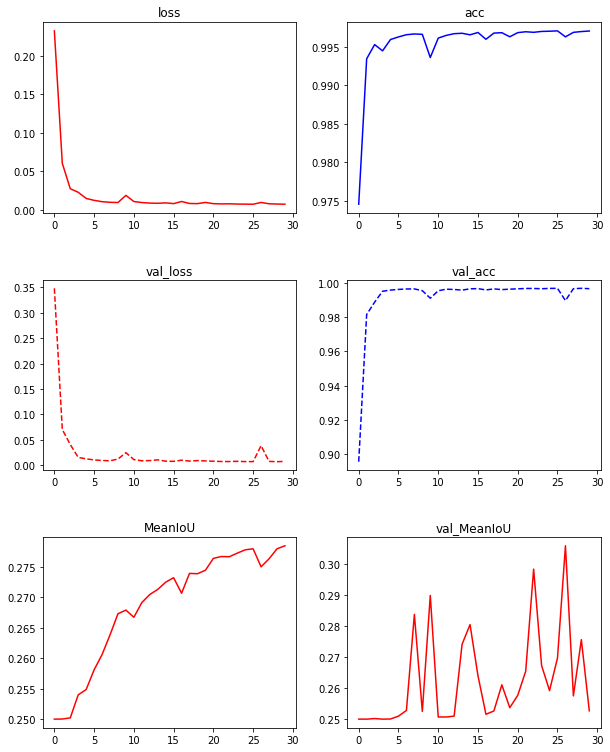

In [6]:
model = VGG16_Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

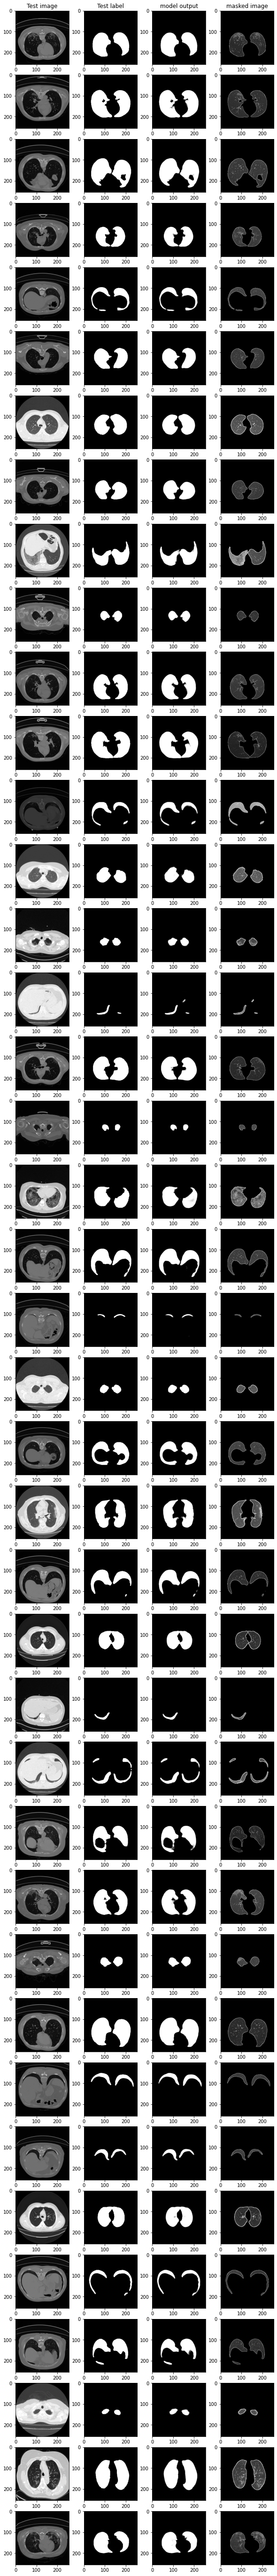

In [7]:
preds = model.predict(x_val)
fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

ax[0, 0].title.set_text("Test image")
ax[0, 1].title.set_text("Test label")
ax[0, 2].title.set_text("model output")
ax[0, 3].title.set_text("masked image")
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    
    y_val_0 = y_val[...,0]
    ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
    predict_0 = preds[...,0]
    ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
    temp = x_val[i]
    pred_sum = predict_0[i][predict_0[i] > 0]
    pred_mean = np.mean(predict_0)
    temp[predict_0[i] < 0.5] = 0
    ax[i, 3].imshow(temp.squeeze(), cmap='gray')
    

In [8]:
y_val_com_0 = y_val[...,0] #image label 
predict_com_0 = preds[...,0] #prediction (model output)

IOU_SUM = 0.0
IOU_AVE = 0.0
Number_image =0

for n,_ in enumerate(y_val_com_0) :
    
    TP = 0
    NP = 0
    index = n
    
    y_label_image = y_val_com_0[index].copy()
    predict_image = predict_com_0[index].copy()

    #model output 0번째 사진의 각 픽셀에 0.5보다 작으면 0 크면 1
    predict_image[predict_image < 0.5] = 0 
    predict_image[predict_image > 0.5] = 1

    #비교 해서 같으면 TP+1 아니면 NP+1
    for i in range(256) :
        for j in range(256) :
            if(y_label_image[i][j] == predict_image[i][j]) :
                TP = TP + 1
            else :
                NP = NP + 1

    print('Number : ', n, 'TP :', TP,'NP : ', NP)
    print('IOU :', TP/ (TP + NP) , '\n')
    IOU_SUM = TP/ (TP + NP) + IOU_SUM
    Number_image = n
    
IOU_AVE = IOU_SUM / (Number_image +  1)
print("IOU_AVE : ", IOU_AVE)


Number :  0 TP : 65377 NP :  159
IOU : 0.9975738525390625 

Number :  1 TP : 65311 NP :  225
IOU : 0.9965667724609375 

Number :  2 TP : 65182 NP :  354
IOU : 0.994598388671875 

Number :  3 TP : 65388 NP :  148
IOU : 0.99774169921875 

Number :  4 TP : 65411 NP :  125
IOU : 0.9980926513671875 

Number :  5 TP : 65404 NP :  132
IOU : 0.99798583984375 

Number :  6 TP : 65439 NP :  97
IOU : 0.9985198974609375 

Number :  7 TP : 65454 NP :  82
IOU : 0.998748779296875 

Number :  8 TP : 65248 NP :  288
IOU : 0.99560546875 

Number :  9 TP : 65459 NP :  77
IOU : 0.9988250732421875 

Number :  10 TP : 65388 NP :  148
IOU : 0.99774169921875 

Number :  11 TP : 65239 NP :  297
IOU : 0.9954681396484375 

Number :  12 TP : 65349 NP :  187
IOU : 0.9971466064453125 

Number :  13 TP : 65370 NP :  166
IOU : 0.997467041015625 

Number :  14 TP : 65377 NP :  159
IOU : 0.9975738525390625 

Number :  15 TP : 65408 NP :  128
IOU : 0.998046875 

Number :  16 TP : 65383 NP :  153
IOU : 0.9976654052734375

Number :  138 TP : 65512 NP :  24
IOU : 0.9996337890625 

Number :  139 TP : 65476 NP :  60
IOU : 0.99908447265625 

Number :  140 TP : 65211 NP :  325
IOU : 0.9950408935546875 

Number :  141 TP : 65267 NP :  269
IOU : 0.9958953857421875 

Number :  142 TP : 65431 NP :  105
IOU : 0.9983978271484375 

Number :  143 TP : 65180 NP :  356
IOU : 0.99456787109375 

Number :  144 TP : 65263 NP :  273
IOU : 0.9958343505859375 

Number :  145 TP : 65427 NP :  109
IOU : 0.9983367919921875 

Number :  146 TP : 65290 NP :  246
IOU : 0.996246337890625 

Number :  147 TP : 65293 NP :  243
IOU : 0.9962921142578125 

Number :  148 TP : 65444 NP :  92
IOU : 0.99859619140625 

Number :  149 TP : 65516 NP :  20
IOU : 0.99969482421875 

Number :  150 TP : 65290 NP :  246
IOU : 0.996246337890625 

Number :  151 TP : 65410 NP :  126
IOU : 0.998077392578125 

Number :  152 TP : 65375 NP :  161
IOU : 0.9975433349609375 

Number :  153 TP : 65445 NP :  91
IOU : 0.9986114501953125 

Number :  154 TP : 65369 NP

Number :  273 TP : 65312 NP :  224
IOU : 0.99658203125 

Number :  274 TP : 65468 NP :  68
IOU : 0.99896240234375 

Number :  275 TP : 65361 NP :  175
IOU : 0.9973297119140625 

Number :  276 TP : 65437 NP :  99
IOU : 0.9984893798828125 

Number :  277 TP : 65448 NP :  88
IOU : 0.9986572265625 

Number :  278 TP : 65306 NP :  230
IOU : 0.996490478515625 

Number :  279 TP : 65393 NP :  143
IOU : 0.9978179931640625 

Number :  280 TP : 65439 NP :  97
IOU : 0.9985198974609375 

Number :  281 TP : 65149 NP :  387
IOU : 0.9940948486328125 

Number :  282 TP : 65317 NP :  219
IOU : 0.9966583251953125 

Number :  283 TP : 65274 NP :  262
IOU : 0.996002197265625 

Number :  284 TP : 65179 NP :  357
IOU : 0.9945526123046875 

Number :  285 TP : 65142 NP :  394
IOU : 0.993988037109375 

Number :  286 TP : 65319 NP :  217
IOU : 0.9966888427734375 

Number :  287 TP : 64704 NP :  832
IOU : 0.9873046875 

Number :  288 TP : 64998 NP :  538
IOU : 0.991790771484375 

Number :  289 TP : 65295 NP :  2